In [1]:
import math
import numpy as np
import scipy
import scipy.optimize
import csv
from scipy.optimize import fsolve

PointConfiguration.set_engine('internal')
#PointConfiguration.set_engine('topcom')
print 'Done.'

def exist(pts, latt):
    latt = np.array(latt)
    for i in range(pts.shape[0]):
        if pts[i][0]==latt[0]:
            if pts[i][1]==latt[1]:
                if pts[i][2]==latt[2]:
                    return 1
    return 0

def contain(poly, latt):
    if poly.contains(latt) == 1:
        return 1
    else:
        poly_latt = Polyhedron(vertices = [tuple(latt)])
        vert = next(poly_latt.vertex_generator())
        face_eq = poly.Hrepresentation()
        for eq in face_eq:
            if eq.contains(vert) != 1:
                return 0
        return 1
    return 0

def check_latt(p):
    pts = np.array(p)
    pts_max = int(max(np.amax(pts, axis=0)))+1
    pts_min = int(min(np.amin(pts, axis=0)))-1
    print 'pts_max and pts_min: ', pts_max, pts_min
    poly = Polyhedron(p)
    pts_new = pts
    for i in range(pts_min, pts_max):
        for j in range(pts_min, pts_max):
            for k in range(pts_min, pts_max):
                latt = [i,j,k]
                if exist(pts, latt) == 1:
                    continue
                if contain(poly, latt) == 1:
                    pts_new = np.append(pts_new, np.array(latt).reshape((1,3)), axis = 0)  
    pts_new = pts_new.tolist()
    return pts_new


def four_cross(v1, v2, v3, v4):
    #Compute cross product of three 4-vectors
    #print "input vectors: ", v1, v2, v3, v4
    v = np.zeros((4,))
    counter = 0
    
    for i in range(4):
        mat = [v1[np.arange(len(v1))!=i].tolist(), v2[np.arange(len(v2))!=i].tolist(), v3[np.arange(len(v3))!=i].tolist()]
        mat = matrix(ZZ, mat)
        #print 'matrix: '
        #print mat
        if counter == 1:
            v[i] = -1*mat.det()
            counter = 0
            #print 'neg: ', v[i]
            continue
        elif counter == 0:
            v[i] = mat.det()
            counter = 1
            #print 'pos: ', v[i]
    #print v
    mat = matrix(RR, [v1.tolist(), v2.tolist(), v3.tolist(), v4.tolist()])
    
    if mat.det() < 0:
        #print 'original: ', v
        v = -1*v
        #print 'changed: ', v
    #print 'vector: ', v
    return v

def Hilb(triang_list):
    triang = []
    # Add 1 at the end of all verticies
    for tetra in triang_list:
        tetra_new = []
        for vert in tetra:
            vert_new = np.append(np.array(vert),1).tolist()
            tetra_new.append(vert_new)
        triang.append(tetra_new)
    triang = np.array(triang)
    # Add 1 to the end of all vectors
    power = np.zeros(shape = triang.shape)
    Hilb = 0
    t = var('t')
    t1 = var('t1')
    t2 = var('t2')
    t3 = var('t3')
    t4 = var('t4')
    for tri in range(triang.shape[0]):
        hilb = 1
        t_prod = 1
        for i in range(4):
            #Multiplying by -1 is optional
            power[tri][i] = -1*four_cross(triang[tri][i], triang[tri][np.remainder(i+1, 4)], triang[tri][np.remainder(i+2, 4)], triang[tri][np.remainder(i+3, 4)])
            t_prod = t1^(int(power[tri][i][0]))*t2^(int(power[tri][i][1]))*t3^(int(power[tri][i][2]))*t4^int((power[tri][i][3]))
            hilb *= (1-t_prod)^(-1)
        #print 'Hilbert: ', hilb
        Hilb += hilb
    print 'Hilb: ', Hilb()
    #print Hilb(t1=t, t2=t, t3=t).series(t4, 3)
    #print "p-q web: ", power 
    
    
    m = var('m')
    b1 = var('b1')
    b2 = var('b2')
    b3 = var('b3')
    b4 = var('b4')
    Hilb *= m^4
    
    #print 'Hilb: ', str(Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*4).exp())).replace('e', 'E')
    Series = Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*4).exp()).series(m==0, 1)
    
    Series = Series.truncate()
    
    return Series

def idx_to_pts(triang, pts):
    # Input a list of lists of indicies
    # Output a list of lists of points
    triang_new = []
    for i in range(len(triang)):
        triang_new.append([pts[j] for j in triang[i]])
    return triang_new

def init_cube(size):
    if size == 0:
        corner = []
        series = 0
        return corner, series
    # Initalize the cube
    cube_1 = [[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,1],[1,0,1],[1,1,1],[0,1,1]]
    corner = (size*np.array(cube_1)).tolist()
    # Sample triangulation of a 1x1x1 cube:
    triang_cube_1_1 = [[[0,0,0],[1,0,0],[1,1,0],[0,0,1]]]
    triang_cube_1_2 = [[[0,0,1],[1,0,1],[1,0,0],[1,1,1]]]
    triang_cube_1_3 = [[[0,0,1],[1,1,1],[1,1,0],[1,0,0]]]
    triang_cube_1_4 = [[[0,0,0],[1,1,0],[0,1,0],[0,0,1]]]
    triang_cube_1_5 = [[[0,0,1],[0,1,1],[1,1,0],[1,1,1]]]
    triang_cube_1_6 = [[[0,0,1],[0,1,1],[0,1,0],[1,1,0]]]
    triang_cube_1 = triang_cube_1_1 + triang_cube_1_2 + triang_cube_1_3 + triang_cube_1_4 + triang_cube_1_5 + triang_cube_1_6
    # Stack the cubes together
    triang = triang_cube_1
    if size == 1:
        return triang
    for x in range(0,size):
        for y in range(0,size):
            for z in range(0,size):
                if x==0 and y==0 and z ==0:
                    continue
                move = [x, y, z]
                move = np.array(move)
                for i in range(6):
                    # The i-th tetrahedron
                    tetra_moved = []
                    for j in range(4):
                        # The j-th vertex
                        vert_moved = (np.array(triang_cube_1[i][j])+move).tolist()
                        tetra_moved.append(vert_moved)
                    triang.append(tetra_moved)
    # Also initialize the Hilbert series for each tetrahedron
    hilb = []
    for tetra in triang:
        series = Hilb([tetra])
        hilb.append(series)
    #print 'Init cube'
    #print 'Hilbert series: ', hilb
    return corner, triang, hilb

def cut_corner(p, corner, triang, hilb):
    corner = check_latt(corner)
    corner.remove(p)
    cube_new = Polyhedron(corner)
    vertices = cube_new.vertices()
    corner = [list(vertices[i]) for i in range(len(vertices))]
    #print 'corner: ', corner
    # Find all the tetrahedron points that contain p
    adj_pts = []
    triang_new = []
    hilb_new = []
   
    for tetra in triang:
        if p in tetra:
            for vertex in tetra:
                if (vertex != p) and (vertex not in adj_pts):
                    adj_pts.append(vertex)
            
            # I do not trust indexing
            series = Hilb([tetra])
            #print 'remove hilb: ', series
            hilb.remove(series)
        else:
            triang_new.append(tetra)
    triang = triang_new
    #print 'adjacent points: ', adj_pts
    if len(adj_pts) > 3:
        patch = Polyhedron(adj_pts)
        patch_triang = PointConfiguration(adj_pts).triangulate()
        patch_triang = idx_to_pts(patch_triang, adj_pts)
        #print 'patch: ', patch_triang
        for tetra in patch_triang:
            if tetra not in triang:
                triang.append(tetra)
            # Also find the Hilbert Series for each tetrahedron
            series = Hilb([tetra])
            #print 'Patch hilbert: ', series
            hilb.append(series)
    #print 'number of tetrahedron: ', len(triang)
    return corner, triang, hilb

# Triangulate Triangular Prism
def init_prism(h):
    if h == 0:
        prism = []
        series = 0
        return prism, series
    prism_1 = [[[0,0,0],[1,0,0],[0,1,0],[1,0,1]]]
    prism_2 = [[[0,0,0],[1,0,1],[0,1,1],[0,1,0]]]
    prism_3 = [[[0,0,0],[1,0,1],[0,0,1],[0,1,1]]]
    prism = prism_1 + prism_2 + prism_3
    if h == 1:
        series = Hilb(prism)
        return prism, series
    prism_stack = prism
    for z in range(1, h):
        move = np.array([0,0,z])
        for i in range(3):
            # For i-th tetrahedron
            tetra_moved = []
            for j in range(4):
                # For j-th vertex:
                vert_moved = (np.array(prism[i][j])+move).tolist()
                tetra_moved.append(vert_moved)
            prism_stack.append(tetra_moved)
    # Also initialize the Hilbert series
    series = Hilb(prism_stack)
    return prism_stack, series

def Triang_prism(h1, h2, h3):
    # Phase 1: Cube blocks up to min(h1, h2, h3)
    h_list = [h1, h2, h3]
    h_min = min(h_list)
    h_list.remove(h_min)
    prism, series = init_prism(h_min)
    # Phase 2: Tetra with min pt as its apex
    h_min_2 = min(h_list)
    for i in range(h_min_2 - h_min):
        # Also find the Hilbert series for each tetrahedron
        prism_1 = [[[1,0,h_min],[0,0,h_min+i],[0,1,h_min+i],[0,1,h_min+i+1]]]
        series_1 = Hilb(prism_1)
        prism_2 = [[[1,0,h_min],[0,0,h_min+i],[0,0,h_min+i+1],[0,1,h_min+i+1]]]
        series_2 = Hilb(prism_2)
        prism += prism_1 + prism_2
        series += series_1 + series_2
    
    # Phase 3: Tetra with max pt as its apex
    h_max = max(h_list)
    for i in range(h_max-h_min_2):
        prism_new = [[[1,0,h_min],[0,0,h_min_2+i],[0,0,h_min_2+i+1],[0,1,h_min_2]]]
        series_new = Hilb(prism_new)
        prism += prism_new
        series += series_new

    return prism, series

# Triangulate the square prism
def init_square_stack(h):
    if h == 0:
        prism = []
        series = 0
        return prism, series
    # Initalize the cube
    cube_1 = [[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,1],[1,0,1],[1,1,1],[0,1,1]]
    # Sample triangulation of a 1x1x1 cube:
    triang_cube_1_1 = [[[0,0,0],[1,0,0],[1,1,0],[0,0,1]]]
    triang_cube_1_2 = [[[0,0,1],[1,0,1],[1,0,0],[1,1,1]]]
    triang_cube_1_3 = [[[0,0,1],[1,1,1],[1,1,0],[1,0,0]]]
    triang_cube_1_4 = [[[0,0,0],[1,1,0],[0,1,0],[0,0,1]]]
    triang_cube_1_5 = [[[0,0,1],[0,1,1],[1,1,0],[1,1,1]]]
    triang_cube_1_6 = [[[0,0,1],[0,1,1],[0,1,0],[1,1,0]]]
    triang_cube_1 = triang_cube_1_1 + triang_cube_1_2 + triang_cube_1_3 + triang_cube_1_4 + triang_cube_1_5 + triang_cube_1_6
    # Stack the cubes together
    triang = triang_cube_1
    if h == 1:
        series = Hilb(triang)
        return triang, series
    for z in range(1, h):
        move = np.array([0,0,z])
        for i in range(6):
            # The i-th tetrahedron
            tetra_moved = []
            for j in range(4):
                # The j-th vertex
                vert_moved = (np.array(triang_cube_1[i][j])+move).tolist()
                tetra_moved.append(vert_moved)
            triang.append(tetra_moved)
    
    hilb = Hilb(triang)
    
    return triang, hilb

def Triang_square(h1,h2,h3,h4, orient):
    
    # Input: ordered heights (1,0,h1), (0,0,h2), (0,1,h2), (1,1,h4)
    # Find the Orientations:
    # Two orientations (trans:0 or cis:1)
    h_list = [h1, h2, h3, h4]
    h_min = min(h_list)
    h_list.remove(h_min)
    h_min_2 = min(h_list)
    h_list.remove(h_min_2)
    h_min_3 = min(h_list)
    h_list.remove(h_min_3)
    h_max = h_list[0]
    assert h_max >= h_min_3 >= h_min_2 >= h_min
    
    # Phase 1: Cube blocks up to h_min
    cube, hilb = init_square_stack(h_min)
    # Phase 2: Tetra transition to triangle base
    if orient == 0:
        # 1243
        for i in range(h_min_2 - h_min):
            prism_1 = [[[1,0,h_min+i],[1,1,h_min],[0,1,h_min+i],[1,0,h_min+i+1]]]
            prism_2 = [[[1,0,h_min+i+1],[1,1,h_min],[0,1,h_min+i],[0,1,h_min+i+1]]]
            prism_3 = [[[0,0,h_min+i],[1,0,h_min+i],[0,1,h_min+i],[0,0,h_min+i+1]]]
            prism_4 = [[[1,0,h_min+i],[1,0,h_min+i+1],[0,0,h_min+i+1],[0,1,h_min+i]]]
            prism_5 = [[[1,0,h_min+i+1],[0,1,h_min+i],[0,1,h_min+i+1],[0,0,h_min+i+1]]]
            prism = prism_1+prism_2+prism_3+prism_4+prism_5
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            series_4 = Hilb(prism_4)
            series_5 = Hilb(prism_5)
            hilb += series_1 + series_2 + series_3 + series_4 + series_5
        
        for i in range(h_min_3 - h_min_2):
            prism_1 = [[[1,0,h_min_2],[1,1,h_min],[0,0,h_min_2+i],[0,0,h_min_2+i+1]]]
            prism_2 = [[[0,0,h_min_2+i],[1,1,h_min],[0,1,h_min_2+i],[0,0,h_min_2+i+1]]]
            prism_3 = [[[0,0,h_min_2+i+1],[0,1,h_min_2+i+1],[0,1,h_min_2+i],[1,1,h_min]]]
            prism = prism_1+prism_2+prism_3
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            hilb += series_1 + series_2 + series_3
        
        for i in range(h_max - h_min_3):
            prism_1 = [[[1,0,h_min_2], [1,1,h_min],[0,0,h_min_3+i],[0,0,h_min_3+i+1]]]
            prism_2 = [[[0,1,h_min_3],[1,1,h_min],[0,0,h_min_3+i],[0,0,h_min_3+i+1]]]
            prism = prism_1+prism_2
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            hilb += series_1 + series_2
        
    if orient == 1:
        # 1234
        for i in range(h_min_2 - h_min):
            prism_1 = [[[1,0,h_min],[1,1,h_min+i],[1,1,h_min+i+1],[0,0,h_min+i+1]]]
            prism_2 = [[[1,0,h_min],[1,1,h_min+i],[0,0,h_min+i],[0,0,h_min+i+1]]]
            prism_3 = [[[0,0,h_min+i],[1,1,h_min+i],[0,1,h_min+i],[0,0,h_min+i+1]]]
            prism_4 = [[[0,0,h_min+i+1],[1,1,h_min+i],[0,1,h_min+i],[1,1,h_min+i+1]]]
            prism_5 = [[[0,0,h_min+i+1],[1,1,h_min+i+1],[0,1,h_min+i],[0,1,h_min+i+1]]]
            prism = prism_1+prism_2+prism_3+prism_4+prism_5
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            series_4 = Hilb(prism_4)
            series_5 = Hilb(prism_5)
            hilb += series_1 + series_2 + series_3 + series_4 + series_5
        
        for i in range(h_min_3 - h_min_2):
            prism_1 = [[[1,0,h_min],[1,1,h_min],[0,0,h_min_2+i],[0,0,h_min_2+i+1]]]
            prism_2 = [[[0,0,h_min_2+i],[1,1,h_min],[0,1,h_min_2+i],[0,0,h_min_2+i+1]]]
            prism_3 = [[[0,0,h_min_2+i+1],[0,1,h_min_2+i+1],[0,1,h_min_2+i],[1,1,h_min]]]
            prism = prism_1+prism_2+prism_3
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            hilb += series_1 + series_2 + series_3
        
        for i in range(h_max - h_min_3):
            prism_1 = [[[1,0,h_min], [1,1,h_min],[0,0,h_min_3+i],[0,0,h_min_3+i+1]]]
            prism_2 = [[[0,1,h_min_3],[1,1,h_min],[0,0,h_min_3+i],[0,0,h_min_3+i+1]]]
            prism = prism_1+prism_2
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            hilb += series_1 + series_2
    if orient == 2:
        # 1423
        for i in range(h_min_2 - h_min):
            prism_1 = [[[1,0,h_min+i],[1,1,h_min+i],[1,1,h_min+i+1],[0,0,h_min+i+1]]]
            prism_2 = [[[1,0,h_min+i],[1,1,h_min+i],[0,0,h_min+i],[0,0,h_min+i+1]]]
            prism_5 = [[[0,0,h_min+i+1],[1,1,h_min+i+1],[1,0,h_min+i],[0,1,h_min]]]
            prism_3 = [[[0,0,h_min+i],[1,1,h_min+i],[0,1,h_min],[0,0,h_min+i+1]]]
            prism_4 = [[[0,0,h_min+i+1],[1,1,h_min+i],[0,1,h_min],[1,1,h_min+i+1]]]
            
            prism = prism_1+prism_2+prism_3+prism_4+prism_5
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            series_4 = Hilb(prism_4)
            series_5 = Hilb(prism_5)
            hilb += series_1 + series_2 + series_3 + series_4 + series_5
        
        
        for i in range(h_min_3 - h_min_2):
            
            prism_1 = [[[1,0,h_min_2],[0,0,h_min_2+i],[1,1,h_min_2+i],[0,0,1+h_min_2+i]]]
            prism_2 = [[[1,0,h_min_2],[1,1,h_min_2+i],[1,1,1+h_min_2+i],[0,0,1+h_min_2+i]]]
            prism_3 = [[[0,0,h_min_2+i],[1,1,h_min_2+i],[0,1,h_min],[0,0,1+h_min_2+i]]]
            prism_4 = [[[1,1,1+h_min_2+i],[1,1,h_min_2+i],[0,1,h_min],[0,0,1+h_min_2+i]]]
            prism = prism_1+prism_2+prism_3+prism_4
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            series_4 = Hilb(prism_4)
            hilb += series_1 + series_2 + series_3 + series_4
        
        
        for i in range(h_max - h_min_3):
            prism_1 = [[[1,0,h_min_2],[1,1,h_min_3],[0,0,h_min_3+i],[0,0,1+h_min_3+i]]]
            prism_2 = [[[0,1,h_min],[1,1,h_min_3],[0,0,h_min_3+i],[0,0,1+h_min_3+i]]]
            prism = prism_1+prism_2
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            hilb += series_1 + series_2
            
    return cube, hilb

def generate_triang_prism(max_height, num_height):
    for height in range(1, max_height+1):
        print 'Height: ', height
        SIDE_LENGTH = int((height+1)/2)
        if num_height <= 1:
            print('Wrong input')
            return -1
        if num_height == 2:
            for h1 in range(1, height+1):
                h2 = height-h1
                if h2 > 0 and h2 <= h1:
                    prism, series = Triang_prism(0, h1, h2)
                    print 'param: ', [0, h1, h2]
                    print 'prism: ', prism
                    print 'series: ', series
        if num_height == 3:
            for h1 in range(1, N+1):
                for h2 in range(1, h1+1):
                    h3 = N-h1-h2
                    if h3 > 0 and h3 <= h2:
                        prism, series = Triang_prism(h1, h2, h3)
                        print 'param: ', [h1, h2, h3]
                        print 'prism: ', prism
                        print 'series: ', series
    print 'Done.'

def check_tri_prism(input_path, output_path):
    input_file = open(input_path, 'r')
    output_file = open(output_path, 'w')
    vol_dict = {}
    counter = 0
    max_count = 100
    for line in input_file:
        if counter >= max_count:
            break
        data = eval(line)
        x = float(data[0][0])
        y = float(data[0][1])
        z = float(data[0][2])
        vol = float(data[1])
        if vol <= 0:
            continue
        key = '%f_%f_%f' % (x,y,z)
        try:
            val = vol_dict[key]
            if abs(val - vol) <= 0.000001:
                continue
            else:
                output_file.write('vol:%f\n'%(vol))
                print 'param: ', x,y,z
                print 'different vol: ', vol
        except:
            vol_dict[key] = vol
            prism, series = Triang_prism(int(x), int(y), int(z))
            output_file.write('\nparam: [%f,%f,%f]\nprism: %s\nseries: %s\nvol: %f\n' % (x,y,z, str(prism), str(series), vol))
        counter += 1
    input_file.close()
    output_file.close()
    print 'Done.'
        
def check_sq_prism(input_path, output_path):
    input_file = open(input_path, 'r')
    output_file = open(output_path, 'w')
    vol_dict = {}
    counter = 0
    max_count = 100
    orient = 0
    for line in input_file:
        if counter >= max_count:
            break
        data = eval(line)
        x = float(data[0][0])
        y = float(data[0][1])
        z = float(data[0][2])
        w = float(data[0][3])
        vol = float(data[1])
        if vol <= 0:
            continue
        key = '%f_%f_%f_%f' % (x,y,z,w)
        try:
            val = vol_dict[key]
            if abs(val - vol) <= 0.000001:
                continue
            else:
                orient = (orient + 1)%2
                output_file.write('orient: %d, vol:%f\n'%(orient, vol))
                print 'param: ', x,y,z,w, orient
                print 'different vol: ', vol
        except:
            vol_dict[key] = vol
            prism, series = Triang_square(int(x), int(y), int(z), int(w), 0)
            output_file.write('\nparam: [%d,%d,%d,%d]\nprism: %s\nseries: %s\norient: %d, vol: %f\n' 
                              % (int(x),int(y),int(z),int(w), str(prism), str(series), 0, vol))
        counter += 1
    input_file.close()
    output_file.close()
    print 'Done.'

def lift_prism(h1, h2, h3):
    # h1 >= h2 >= h3
    h_list = [h1, h2, h3]
    h_min = min(h_list)
    h_list.remove(h_min)
    h_max = max(h_list)
    h_list.remove(h_max)
    h_mid = h_list[0]
    
    
    if h_min == 0:
        prism = []
        series = 0
        if h_mid > 0:
            for i in range(h_mid):
                prism_1 = [[[1,0,0],[1,1,0],[0,0,i],[0,0,i+1]]]
                prism_2 = [[[0,0,i],[1,1,0],[0,1,i],[0,0,i+1]]]
                prism_3 = [[[1,1,0],[0,1,i],[0,1,i+1],[0,0,i+1]]]
                prism += prism_1 + prism_2 + prism_3

                series_1 = Hilb(prism_1)
                series_2 = Hilb(prism_2)
                series_3 = Hilb(prism_3)
                series += series_1 + series_2 + series_3
        
            for i in range(h_mid, h_max):
                prism_1 = [[[1,0,0],[1,1,0],[0,0,h_mid+i],[0,0,h_mid+i+1]]]
                prism_2 = [[[1,1,0],[0,1,h_mid+i],[0,0,h_mid+i],[0,0,h_mid+i+1]]]
                prism += prism_1 + prism_2

                series_1 = Hilb(prism_1)
                series_2 = Hilb(prism_2)
                series += series_1 + series_2
        elif h_mid == 0:
            for i in range(h_max):
                prism_1 = [[[1,0,0],[1,1,0],[0,0,i],[0,0,i+1]]]
                prism_2 = [[[0,0,i],[1,1,0],[0,1,0],[0,0,i+1]]]
                prism += prism_1 + prism_2
                
                series_1 = Hilb(prism_1)
                series_2 = Hilb(prism_2)
                series += series_1 + series_2
            
        return prism, series
    
    if h_min > 0:
        # Stage 0: base
        prism = [[[1,0,0],[0,0,0],[0,1,0],[1,1,h_min]]]
        series = Hilb(prism)
        # Stage 1: h1 = h2
        for i in range(h_mid):
            prism_1 = [[[1,0,0],[0,0,i],[0,0,i+1],[1,1,h_min]]]
            prism_2 = [[[0,0,i],[0,1,i],[1,1,h_min],[0,0,i+1]]]
            prism_3 = [[[0,1,i],[0,1,i+1],[0,0,i+1],[1,1,h_min]]]
            prism += prism_1 + prism_2 + prism_3
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            series += series_1 + series_2 + series_3
            
        for i in range(h_mid, h_max):
            prism_1 = [[[1,0,0],[1,1,h_min],[0,0,i],[0,0,i+1]]]
            prism_2 = [[[1,1,h_min],[0,0,i],[0,1,i],[0,0,i+1]]]
            prism += prism_1 + prism_2
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series += series_1 + series_2
    
    return prism, series

print 'Done.'

Done.
Done.


In [2]:
for N in range(1,6):
    for h1 in range(1,N+1):
        for h2 in range(0,h1+1):
            h3 = N - h1 -h2
            if h3 >= 0 and h3 <= h2:
                print h1,h2,h3
                prism, series = lift_prism(h1, h2, h3)
                print series
                print ''

1 0 0
1/((b1 - b2)*b1*(b2 + b3 - 4)*b3) - 1/((b1 - b2)*(b1 + b3 - 4)*b2*b3)

1 1 0
1/((b1 + b3 - 4)*b1*(b2 + b3 - 4)*(b2 - 4)) + 1/((b1 - b2)*b1*(b2 + b3 - 4)*b3) - 1/((b1 - b2)*(b1 + b3 - 4)*b2*b3)

2 0 0
1/((b1 - b2)*b1*(2*b2 + b3 - 8)*(b2 + b3 - 4)) - 1/((2*b1 + b3 - 8)*(b1 - b2)*(b1 + b3 - 4)*b2) + 1/((b1 - b2)*b1*(b2 + b3 - 4)*b3) - 1/((b1 - b2)*(b1 + b3 - 4)*b2*b3)

1 1 1
1/((b1 - b2 - b3 + 4)*(b1 - b2)*(b1 - b3)*b1) + 1/((b1 - b2 + b3 - 4)*(b1 - b2)*(b2 - b3)*b2) - 1/((b1 - b2 - b3 + 4)*b1*(b2 - 4)*(b3 - 4)) - 1/((b1 + b2 - b3 - 4)*(b1 - b3)*(b2 - b3)*b3)

2 1 0
1/((2*b1 + b2 + b3 - 12)*(2*b1 + b3 - 8)*(b1 - b2)*b1) + 1/((b1 + b3 - 4)*b1*(b2 + b3 - 4)*(b2 - 4)) - 1/((3*b1 + b3 - 12)*(2*b1 + b3 - 8)*(b1 - b2)*b2) + 1/((b1 - b2)*b1*(b2 + b3 - 4)*b3) - 1/((b1 - b2)*(b1 + b3 - 4)*b2*b3)

3 0 0
1/((b1 - b2)*b1*(3*b2 + b3 - 12)*(2*b2 + b3 - 8)) + 1/((b1 - b2)*b1*(2*b2 + b3 - 8)*(b2 + b3 - 4)) - 1/((3*b1 + b3 - 12)*(2*b1 + b3 - 8)*(b1 - b2)*b2) - 1/((2*b1 + b3 - 8)*(b1 - b2)*(b1 + b3 -

In [ ]:
prism, series = 

In [19]:
p1 = [1,0,0]
p2 = [0,1,0]
p3 = [0,0,1]
p4 = [-1,-1,-1]
p5 = [0,0,0]
pts = [p1,p2,p3,p4,p5]
prism = []
prism_idx = [[1,2,3,5],[1,2,4,5],[1,3,4,5],[2,3,4,5]]
counter = 0
for group in prism_idx:
    prism.append([])
    for p in group:
        prism[counter].append(pts[p-1])
    
    counter += 1
print prism
print Hilb(prism)

[[[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0]], [[1, 0, 0], [0, 1, 0], [-1, -1, -1], [0, 0, 0]], [[1, 0, 0], [0, 0, 1], [-1, -1, -1], [0, 0, 0]], [[0, 1, 0], [0, 0, 1], [-1, -1, -1], [0, 0, 0]]]
Hilb:  1/((t1^3*t4/(t2*t3) - 1)*(t2/t1 - 1)*(t3/t1 - 1)*(1/t1 - 1)) + 1/((t2^3*t4/(t1*t3) - 1)*(t1/t2 - 1)*(t3/t2 - 1)*(1/t2 - 1)) + 1/((t3^3*t4/(t1*t2) - 1)*(t1/t3 - 1)*(t2/t3 - 1)*(1/t3 - 1)) + 1/((t1 - 1)*(t2 - 1)*(t3 - 1)*(t4/(t1*t2*t3) - 1))
1/4/((b1 - b2)*(b1 - b3)*b1*(b2 + b3 - 3)) - 1/4/((b1 - b2)*(b1 + b3 - 3)*(b2 - b3)*b2) + 1/4/((b1 + b2 - 3)*(b1 - b3)*(b2 - b3)*b3) - 1/4/((b1 + b2 + b3 - 3)*b1*b2*b3)


In [35]:
m = var('m')
x = var('x')
y = var('y')
z = var('z')

f = 1/((1 - x*y/z) (1 - z/x) (1 - z/y)) + 1/((1 - x) (1 - y) (1 - z/(x*y)))

b1 = var('b1')
b2 = var('b2')
b3 = var('b3')
b4 = var('b4')
f *= m**3
f = f(x = (m*b1).exp(), y = (m*b2).exp(), z = (m*3).exp())
print f
#print 'Hilb: ', str(Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*4).exp())).replace('e', 'E')


#Series = Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*(2-b1-b2-b3)).exp()).series(m==0, 1)
Series = f.series(m==0, 1)
print Series
Series = Series.truncate()


-m^3*(1/((e^(3*m)/(e^(-b2*m + 3*m) - 1) + 1)*e^(b2*m - 3*m) - 1) + 1/(e^(-b1*m - b2*m + 3*m) - 1))
Order(m)


In [39]:
triang = '{{{1, 0, 0}, {0, 1, 0}, {0, 0, 1}, {0, 0, 0}},{{1, 0, 0}, {0, 1, 0}, {0, 0, 1}, {0, 1, 1}}}'
triang = triang.replace('{', '[')
triang = triang.replace('}', ']')
triang = eval(triang)
print triang
print Hilb(triang)
print ''
prism, series = lift_prism(1,0,0)
print prism
print series

[[[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0]], [[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 1]]]
Hilb:  1/((t1*t2*t3/t4 - 1)*(t1 - 1)*(t4/(t1*t2) - 1)*(t4/(t1*t3) - 1)) + 1/((t1 - 1)*(t2 - 1)*(t3 - 1)*(t4/(t1*t2*t3) - 1))
1/((b1 + b2 + b3 - 4)*(b1 + b2 - 4)*(b1 + b3 - 4)*b1) - 1/((b1 + b2 + b3 - 4)*b1*b2*b3)

Hilb:  1/((t2 - 1)*(t3 - 1)*(t1/t2 - 1)*(t4/(t1*t3) - 1))
Hilb:  1/((t1 - 1)*(t3 - 1)*(t2/t1 - 1)*(t4/(t2*t3) - 1))
[[[1, 0, 0], [1, 1, 0], [0, 0, 0], [0, 0, 1]], [[0, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 1]]]
1/((b1 - b2)*b1*(b2 + b3 - 4)*b3) - 1/((b1 - b2)*(b1 + b3 - 4)*b2*b3)


In [10]:
prism, series = lift_prism(1,1,1)
print prism
print series

Hilb:  1/((t3 - 1)*(t1/t3 - 1)*(t2/t3 - 1)*(t3*t4/(t1*t2) - 1))
Hilb:  1/((t2 - 1)*(t1/t2 - 1)*(t3/t2 - 1)*(t2*t4/(t1*t3) - 1))
Hilb:  1/((t1 - 1)*(t2/t1 - 1)*(t3/t1 - 1)*(t1*t4/(t2*t3) - 1))
Hilb:  1/((t1 - 1)*(t2*t3/(t1*t4) - 1)*(t4/t2 - 1)*(t4/t3 - 1))
[[[1, 0, 0], [0, 0, 0], [0, 1, 0], [1, 1, 1]], [[1, 0, 0], [0, 0, 0], [0, 0, 1], [1, 1, 1]], [[0, 0, 0], [0, 1, 0], [1, 1, 1], [0, 0, 1]], [[0, 1, 0], [0, 1, 1], [0, 0, 1], [1, 1, 1]]]
1/((b1 - b2 - b3 + 4)*(b1 - b2)*(b1 - b3)*b1) + 1/((b1 - b2 + b3 - 4)*(b1 - b2)*(b2 - b3)*b2) - 1/((b1 - b2 - b3 + 4)*b1*(b2 - 4)*(b3 - 4)) - 1/((b1 + b2 - b3 - 4)*(b1 - b3)*(b2 - b3)*b3)


In [12]:
prism, series = lift_prism(2,2,2)
print prism
print series

Hilb:  1/((t1^2/t3 - 1)*(t2^2/t3 - 1)*(t3 - 1)*(t3*t4^2/(t1^2*t2^2) - 1))
Hilb:  1/((t2 - 1)*(t2^2*t4/(t1*t3) - 1)*(t1/t2 - 1)*(t3/t2^2 - 1))
Hilb:  1/((t1 - 1)*(t1^2*t4/(t2*t3) - 1)*(t2/t1 - 1)*(t3/t1^2 - 1))
Hilb:  1/((t1 - 1)*(t1*t4/t3 - 1)*(t4/t2 - 1)*(t2*t3/(t1^2*t4) - 1))
Hilb:  1/((t2 - 1)*(t2^2*t4^2/(t1^2*t3) - 1)*(t1/t2 - 1)*(t1*t3/(t2^2*t4) - 1))
Hilb:  1/((t1 - 1)*(t1*t4^2/(t2*t3) - 1)*(t2/t1 - 1)*(t3/(t1*t4) - 1))
Hilb:  1/((t1 - 1)*(t4^2/t3 - 1)*(t4/t2 - 1)*(t2*t3/(t1*t4^2) - 1))
[[[1, 0, 0], [0, 0, 0], [0, 1, 0], [1, 1, 2]], [[1, 0, 0], [0, 0, 0], [0, 0, 1], [1, 1, 2]], [[0, 0, 0], [0, 1, 0], [1, 1, 2], [0, 0, 1]], [[0, 1, 0], [0, 1, 1], [0, 0, 1], [1, 1, 2]], [[1, 0, 0], [0, 0, 1], [0, 0, 2], [1, 1, 2]], [[0, 0, 1], [0, 1, 1], [1, 1, 2], [0, 0, 2]], [[0, 1, 1], [0, 1, 2], [0, 0, 2], [1, 1, 2]]]
1/((2*b1 - b2 - b3 + 4)*(2*b1 - b3)*(b1 - b2)*b1) + 1/((b1 - b2 - b3 + 8)*(b1 - b2)*(b1 - b3 + 4)*b1) + 1/((2*b1 - b2 - b3 + 4)*(b1 - b3 + 4)*b1*(b2 - 4)) - 1/((2*b1 - 2*b2 + b3 -

In [24]:
max_height = 2
vol_list = []
data_list = []
data_list_failed = []
min_vol_global = 100.0
vol_dict = {}
for h1 in range(1, max_height+1):
    SIDE_LENGTH = h1
    print h1,0,0
    vol = np.random.random_sample()
    max_vol = vol
    vol_dict['%d_%d_%d' % (h1,0,0)] = max_vol
    #prism, series = lift_prism(h1,0,0)
    #vol,sol = expand_NSolve(series, 5, SIDE_LENGTH, out_file)
    #max_vol = vol
    print h1,h1,h1
    vol = np.random.random_sample()
    min_vol = vol
    vol_dict['%d_%d_%d' % (h1,h1,h1)] = min_vol
    #prism, series = lift_prism(h1,h1,0)
    #vol,sol = expand_NSolve(series, 5, SIDE_LENGTH, out_file)
    #min_vol = vol
    max_vol_set = max_vol
    min_vol_set = min_vol
    print 'max_vol_set: ', max_vol_set
    print 'min_vol_set: ', min_vol_set
    if max_vol_set <= min_vol_set:
        print 'weird'
        data_list_failed.append([[h1,0,0], max_vol_set])
        data_list_failed.append([[h1,h1,h1], min_vol_set])
        max_vol_set = 16.0/27/h1
        min_vol_set = min(1/(float(h1+1)**3), min_vol_global)
    elif min_vol_set < min_vol_global:
        min_vol_global = min_vol
        print 'update min_vol_global: ', min_vol_global
    vol_list_set = []
    num_vol = 0
    max_vol_idx = 0
    for h2 in range(1, h1+1):
        for h3 in range(0,h2+1):
            try:
                vol_tmp = vol_dict['%d_%d_%d' % (h1,h2,h3)]
                print 'volume already found: ', vol_tmp, ' for ', h1,h2,h3
                continue
            except:
                pass
            if h3 >= 0 and h3 <= h2:
                print '===', h1,h2,h3, '==='
                vol = -1
                vol_dict['%d_%d_%d' % (h1,h2,h3)] = vol
                # Start with previous volume as maximum
                print 'max_vol_idx: ', max_vol_idx
                try:
                    max_vol = vol_list_set[max_vol_idx]
                    print 'max_vol: ', max_vol
                    print 'min_vol: ', min_vol
                    while max_vol == -1 and max_vol_idx > 0:
                        max_vol_idx -= 1
                        max_vol = vol_list_set[max_vol_idx]
                        print 'decrease max_vol_idx: ', max_vol_idx
                        print 'increase max_vol: ', max_vol
                except:
                    max_vol = max_vol_set
                    min_vol = min_vol_set
                while vol == -1:
                    min_vol = min_vol_set
                    print 'bound: ', max_vol, min_vol
                    vol = np.random.random_sample()
                    if vol == -1 or vol > 1:
                        print 'Wrong volume: ', vol
                        data_list_failed.append([[h1,h2,h3], vol])
                        break
                    print 'try vol: ', vol
                    # if cannot find result in this range
                    # try to expand the max
                    # until the set max is achieved
                    if vol > max_vol:
                        print 'too large'
                        if vol > max_vol_set:
                            print 'way too large'
                            max_vol = 1
                            vol = -1
                            continue
                        if max_vol < max_vol_set:
                            try:
                                print 'increase max_vol, decrease max_vol_idx: ', max_vol_idx
                                if max_vol_idx > 0:
                                    max_vol_idx -= 1
                                    max_vol = vol_list_set[max_vol_idx]
                                    print 'max_vol_idx: ', max_vol_idx
                                    print 'max_vol: ', max_vol
                                    print 'continue'
                                    vol = -1
                                    continue
                            except:
                                print 'set max_vol, ', max_vol, ' to largest in set ', max_vol_set
                                max_vol = max_vol_set
                                vol = -1
                                continue
                        #vol_list.append(-1)
                        data_list_failed.append([[h1,h2,h3], vol])
                        continue
                    if vol < min_vol:
                        print 'too small'
                        if vol < min_vol_global:
                            print 'volume way too small'
                            #vol_list_set.append(-1)
                            data_list_failed.append([[h1,h2,h3], vol])
                            continue
                        if vol < min_vol_set:
                            print 'set min_vol, ', min_vol, ' to smallest global ', min_vol_global
                            min_vol = min_vol_global
                            vol = -1
                            continue
                        if vol < min_vol:
                            print 'set min_vol, ', min_vol, ' to smallest in set ', min_vol_set
                            min_vol = min_vol_set
                            vol = -1
                            continue
                    else:
                        vol_list_set.append(vol)
                        vol_list.append(vol)
                        num_vol += 1
                        data_list.append([[h1,h2,h3], vol])
                        vol_dict['%d_%d_%d' % (h1,h2,h3)] = vol
                    print 'Done.'
                    print 'update vol_list_set: ', vol_list_set
                    print 'update data_list: ', data_list 
print 'vol_list: ', vol_list
print 'vol_dict: ', vol_dict
print 'data_list: ', data_list
print 'data_list_failed: ', data_list_failed
print 'combined data_list: ', data_list+data_list_failed

1 0 0
1 1 1
max_vol_set:  0.0293352840717
min_vol_set:  0.929143026347
weird
=== 1 1 0 ===
max_vol_idx:  0
bound:  0.592592592592593 0.125
try vol:  0.890075276328
too large
way too large
bound:  1 0.125
try vol:  0.477024481069
Done.
update vol_list_set:  [0.477024481069125]
update data_list:  [[[1, 1, 0], 0.477024481069125]]
volume already found:  0.929143026347  for  1 1 1
2 0 0
2 2 2
max_vol_set:  0.297376158277
min_vol_set:  0.692180955066
weird
=== 2 1 0 ===
max_vol_idx:  0
bound:  0.296296296296296 0.037037037037
try vol:  0.866955302129
too large
way too large
bound:  1 0.037037037037
try vol:  0.910804264783
Done.
update vol_list_set:  [0.9108042647834311]
update data_list:  [[[1, 1, 0], 0.477024481069125], [[2, 1, 0], 0.9108042647834311]]
=== 2 1 1 ===
max_vol_idx:  0
max_vol:  0.910804264783
min_vol:  0.037037037037
bound:  0.910804264783 0.037037037037
try vol:  0.168767683916
Done.
update vol_list_set:  [0.9108042647834311, 0.16876768391629482]
update data_list:  [[[1, 1, 

In [ ]:
# Idea: no max limit (i.e. max is 1)
# Only min limit set to whatever is smallest
max_height = 2
min_vol_global = 100.0
vol_dict = {}
# Data of vol_dict: [vol, sol, check]
for h1 in range(1, max_height+1):
    SIDE_LENGTH = h1
    print h1,0,0
    vol = np.random.random_sample()
    max_vol = vol
    vol_dict['%d_%d_%d' % (h1,0,0)] = max_vol
    
    print h1,h1,h1
    vol = np.random.random_sample(2)
    min_vol = vol
    vol_dict['%d_%d_%d' % (h1,h1,h1)] = min_vol
    
    max_vol_set = max_vol
    min_vol_set = min_vol
    print 'max_vol_set: ', max_vol_set
    print 'min_vol_set: ', min_vol_set
    
    if max_vol_set <= min_vol_set:
        print 'weird'
        data_list_failed.append([[h1,0,0], max_vol_set])
        data_list_failed.append([[h1,h1,h1], min_vol_set])
        max_vol_set = 16.0/27/h1
        min_vol_set = min(1/(float(h1+1)**3), min_vol_global)
    elif min_vol_set < min_vol_global:
        min_vol_global = min_vol
        print 'update min_vol_global: ', min_vol_global
    vol_list_set = []
    num_vol = 0
    max_vol_idx = 0
    for h2 in range(1, h1+1):
        for h3 in range(0,h2+1):
            try:
                vol_tmp = vol_dict['%d_%d_%d' % (h1,h2,h3)]
                print 'volume already found: ', vol_tmp, ' for ', h1,h2,h3
                continue
            except:
                pass
            if h3 >= 0 and h3 <= h2:
                print '===', h1,h2,h3, '==='
                vol = -1
                vol_dict['%d_%d_%d' % (h1,h2,h3)] = vol
                # Start with previous volume as maximum
                print 'max_vol_idx: ', max_vol_idx
                try:
                    max_vol = vol_list_set[max_vol_idx]
                    print 'max_vol: ', max_vol
                    print 'min_vol: ', min_vol
                    while max_vol == -1 and max_vol_idx > 0:
                        max_vol_idx -= 1
                        max_vol = vol_list_set[max_vol_idx]
                        print 'decrease max_vol_idx: ', max_vol_idx
                        print 'increase max_vol: ', max_vol
                except:
                    max_vol = max_vol_set
                    min_vol = min_vol_set
                while vol == -1:
                    min_vol = min_vol_set
                    print 'bound: ', max_vol, min_vol
                    vol = np.random.random_sample()
                    if vol == -1 or vol > 1:
                        print 'Wrong volume: ', vol
                        data_list_failed.append([[h1,h2,h3], vol])
                        break
                    print 'try vol: ', vol
                    # if cannot find result in this range
                    # try to expand the max
                    # until the set max is achieved
                    if vol > max_vol:
                        print 'too large'
                        if vol > max_vol_set:
                            print 'way too large'
                            max_vol = 1
                            vol = -1
                            continue
                        if max_vol < max_vol_set:
                            try:
                                print 'increase max_vol, decrease max_vol_idx: ', max_vol_idx
                                if max_vol_idx > 0:
                                    max_vol_idx -= 1
                                    max_vol = vol_list_set[max_vol_idx]
                                    print 'max_vol_idx: ', max_vol_idx
                                    print 'max_vol: ', max_vol
                                    print 'continue'
                                    vol = -1
                                    continue
                            except:
                                print 'set max_vol, ', max_vol, ' to largest in set ', max_vol_set
                                max_vol = max_vol_set
                                vol = -1
                                continue
                        #vol_list.append(-1)
                        data_list_failed.append([[h1,h2,h3], vol])
                        continue
                    if vol < min_vol:
                        print 'too small'
                        if vol < min_vol_global:
                            print 'volume way too small'
                            #vol_list_set.append(-1)
                            data_list_failed.append([[h1,h2,h3], vol])
                            continue
                        if vol < min_vol_set:
                            print 'set min_vol, ', min_vol, ' to smallest global ', min_vol_global
                            min_vol = min_vol_global
                            vol = -1
                            continue
                        if vol < min_vol:
                            print 'set min_vol, ', min_vol, ' to smallest in set ', min_vol_set
                            min_vol = min_vol_set
                            vol = -1
                            continue
                    else:
                        vol_list_set.append(vol)
                        vol_list.append(vol)
                        num_vol += 1
                        data_list.append([[h1,h2,h3], vol])
                        vol_dict['%d_%d_%d' % (h1,h2,h3)] = vol
                    print 'Done.'
                    print 'update vol_list_set: ', vol_list_set
                    print 'update data_list: ', data_list 
print 'vol_list: ', vol_list
print 'vol_dict: ', vol_dict
print 'data_list: ', data_list
print 'data_list_failed: ', data_list_failed
print 'combined data_list: ', data_list+data_list_failed

In [14]:
import numpy as np
max_height = 3
vol_dict = {}
vol_list = []
num_vol = 0
vol_min_global = 1
for h1 in range(1, max_height+1):
    print h1, 0, 0
    num_vol_prev = (h1+1)*h1/2
    num_vol_prev = - num_vol_prev - 1
    #print 'num_vol_prev: ', num_vol_prev
    try:
        max_vol = vol_list[num_vol_prev]
    except:
        max_vol = 1
    min_vol_tmp = 16.0/27/(h1)*0.8
    min_vol = min_vol_tmp
    vol = np.random.random_sample()
    print 'bound: ', max_vol, min_vol
    vol_dict['%d_%d_%d' % (h1,0,0)] = vol
    vol_list.append(vol)
    num_vol += 1
    print 'vol: ', vol
    
#     if vol < vol_min_global:
#         vol_min_global = vol
    
    max_vol_h1 = vol
    
    for h2 in range(0, h1+1):
        h2 = h1 - h2
        max_vol = max_vol_h1
        for h3 in range(0, h2+1):
            h3 = h2 - h3
            try:
                vol_tmp = vol_dict['%d_%d_%d' % (h1,h2,h3)]
                #print 'volume already found: ', vol_tmp, ' for ', h1,h2,h3
                continue
            except:
                pass
            print h1,h2,h3
            if h3 == h2:
                min_vol = vol_min_global
            else:
                try:
                    min_vol = vol_list[-1]
                except:
                    min_vol = vol_min_global
            vol = np.random.random_sample()
            print 'bound: ', max_vol, min_vol
            vol_dict['%d_%d_%d' % (h1,h2,h3)] = vol
            vol_list.append(vol)
            num_vol += 1
            print 'vol: ', vol
    print vol_list
            

1 0 0
bound:  1 0.125000000000000
vol:  0.000739289945521
1 1 1
bound:  0.000739289945521 0.125000000000000
vol:  0.589103124831
1 1 0
bound:  0.000739289945521 0.589103124831
vol:  0.950163188432
[0.0007392899455209712, 0.5891031248305787, 0.9501631884324588]
2 0 0
bound:  1 0.0370370370370370
vol:  0.288475723562
2 2 2
bound:  0.288475723562 0.0370370370370370
vol:  0.200537820031
2 2 1
bound:  0.288475723562 0.200537820031
vol:  0.68334021312
2 2 0
bound:  0.288475723562 0.68334021312
vol:  0.206623388142
2 1 1
bound:  0.288475723562 0.0370370370370370
vol:  0.230468313479
2 1 0
bound:  0.288475723562 0.230468313479
vol:  0.676327125044
[0.0007392899455209712, 0.5891031248305787, 0.9501631884324588, 0.288475723561734, 0.20053782003119813, 0.6833402131201013, 0.20662338814188685, 0.230468313478711, 0.6763271250443785]
3 0 0
bound:  0.950163188432 0.0156250000000000
vol:  0.105775975117
3 3 3
bound:  0.105775975117 0.0156250000000000
vol:  0.200500768408
3 3 2
bound:  0.105775975117 0

In [2]:
import numpy as np
max_height = 5
vol_dict = {}
vol_list = []
num_vol = 0
vol_min_global = 1
for h1 in range(3, max_height+1):
    print h1, 0, 0
    num_vol_prev = (h1+1)*h1/2
    num_vol_prev = - num_vol_prev
    print 'num_vol_prev: ', num_vol_prev
    
    # we assume that vol(h1,0,0) is going to be
    # smaller than vol(h1-1,0,0), and that it is
    # probably close to 16/27/h1
    try:
        max_vol = vol_list[num_vol_prev]
        print 'max_vol: ', max_vol
    except:
        max_vol = 1
    min_vol_tmp = 16.0/27/(h1)
    min_vol = min_vol_tmp
    target_vol = min_vol
    max_range = abs(max_vol - min_vol)
    
    print 'target: ', target_vol, ', range: ', max_range
    vol = np.random.random_sample()
    print 'vol: ', vol
    vol_dict['%d_%d_%d' % (h1,0,0)] = vol
    vol_list.append(vol)
    num_vol += 1
    target_vol = vol
    max_range = abs(target_vol - min_vol)
#     if vol < vol_min_global:
#         vol_min_global = vol
    
    for h2 in range(0, h1+1):
        h2 = h1 - h2
        for h3 in range(0, h2+1):
            h3 = h2 - h3
            try:
                vol_tmp = vol_dict['%d_%d_%d' % (h1,h2,h3)]
                continue
            except:
                pass
            print h1,h2,h3
            vol = np.random.random_sample()
            print 'target: ', target_vol, ', range: ', max_range
            vol_dict['%d_%d_%d' % (h1,h2,h3)] = vol
            vol_list.append(vol)
            num_vol += 1
            print 'vol: ', vol
    print vol_list
            

3 0 0
num_vol_prev:  -6
target:  0.197530864197531 , range:  0.802469135802469
vol:  0.82999065639
3 3 3
target:  0.82999065639 , range:  0.632459792192283
vol:  0.089007709102
3 3 2
target:  0.82999065639 , range:  0.632459792192283
vol:  0.134360026513
3 3 1
target:  0.82999065639 , range:  0.632459792192283
vol:  0.0180501188115
3 3 0
target:  0.82999065639 , range:  0.632459792192283
vol:  0.269839766596
3 2 2
target:  0.82999065639 , range:  0.632459792192283
vol:  0.714433964227
3 2 1
target:  0.82999065639 , range:  0.632459792192283
vol:  0.298270283963
3 2 0
target:  0.82999065639 , range:  0.632459792192283
vol:  0.517139317366
3 1 1
target:  0.82999065639 , range:  0.632459792192283
vol:  0.835469389073
3 1 0
target:  0.82999065639 , range:  0.632459792192283
vol:  0.209693622011
[0.8299906563898142, 0.08900770910203626, 0.1343600265130397, 0.01805011881150531, 0.26983976659604436, 0.7144339642271573, 0.2982702839634226, 0.5171393173657687, 0.8354693890729387, 0.209693622011

In [3]:
file_path = '/home/carnd/CYML/triangulate/lift_vol_1_10.txt'
data_file = open(file_path, 'r')
num_data = 285
heights_list = [0]*int(num_data)
volume_list = [0]*int(num_data)

for line in data_file:
    data = line.split('>>>')
    heights = data[0].split('_')
    #print heights
    if len(heights) != 3:
        continue
    h1 = eval(heights[0])
    h2 = eval(heights[1])
    h3 = eval(heights[2])
    volume = eval(data[1])
    idx_1 = 0
    idx_2 = 0
    idx_3 = 0
    for i in range(1,h1+1):
        idx_1 += i*(i+1)/2
    idx_1 -= 1
    idx_2 = (h2)*(h2+1)/2
    idx_3 = h3
    idx = idx_1 + idx_2 + idx_3
    #print 'idx: ', idx
    heights_list[idx] = [h1,h2,h3]
    volume_list[idx] = volume[0]
data_file.close()

In [4]:
print heights_list
print volume_list

[[1, 0, 0], [1, 1, 0], [1, 1, 1], [2, 0, 0], [2, 1, 0], [2, 1, 1], [2, 2, 0], [2, 2, 1], [2, 2, 2], [3, 0, 0], [3, 1, 0], [3, 1, 1], [3, 2, 0], [3, 2, 1], [3, 2, 2], [3, 3, 0], [3, 3, 1], [3, 3, 2], [3, 3, 3], [4, 0, 0], [4, 1, 0], [4, 1, 1], [4, 2, 0], [4, 2, 1], [4, 2, 2], [4, 3, 0], [4, 3, 1], [4, 3, 2], [4, 3, 3], [4, 4, 0], [4, 4, 1], [4, 4, 2], [4, 4, 3], [4, 4, 4], [5, 0, 0], [5, 1, 0], [5, 1, 1], [5, 2, 0], [5, 2, 1], [5, 2, 2], [5, 3, 0], [5, 3, 1], [5, 3, 2], [5, 3, 3], [5, 4, 0], [5, 4, 1], [5, 4, 2], [5, 4, 3], [5, 4, 4], [5, 5, 0], [5, 5, 1], [5, 5, 2], [5, 5, 3], [5, 5, 4], [5, 5, 5], [6, 0, 0], [6, 1, 0], [6, 1, 1], [6, 2, 0], [6, 2, 1], [6, 2, 2], [6, 3, 0], [6, 3, 1], [6, 3, 2], [6, 3, 3], [6, 4, 0], [6, 4, 1], [6, 4, 2], [6, 4, 3], [6, 4, 4], [6, 5, 0], [6, 5, 1], [6, 5, 2], [6, 5, 3], [6, 5, 4], [6, 5, 5], [6, 6, 0], [6, 6, 1], [6, 6, 2], [6, 6, 3], [6, 6, 4], [6, 6, 5], [6, 6, 6], [7, 0, 0], [7, 1, 0], [7, 1, 1], [7, 2, 0], [7, 2, 1], [7, 2, 2], [7, 3, 0], [7, 3, 1]

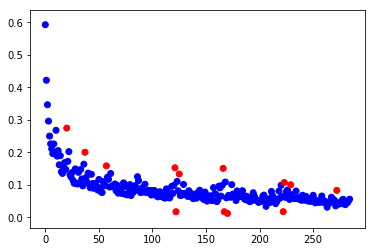

In [34]:
import numpy as np
import matplotlib.pyplot as plt

off_list = [20, 37, 57, 121, 122, 125, 166, 167, 170, 222, 223, 229, 272]
x = volume_list
y = np.arange(len(volume_list))
color = []
for i in range(len(volume_list)):
    if y[i] in off_list:
        color.append('r')
    else:
        color.append('b')
plt.scatter(y, x, c=color)
plt.show()

In [26]:
off_list = [20, 37, 57, 121, 122, 125, 166, 167, 170, 222, 223, 229, 272]
for i in range(len(x)):
    if y[i] in off_list:
        print y[i], x[i]

57 0.158737617439


In [30]:
x = np.random.random(10)*10
y = np.random.random(10)*10

col = np.where(x<1,'k',np.where(y<5,'b','r'))
print x
print y
print col

[ 2.61581407  7.38911898  9.27102148  4.42504755  1.36169719  2.83450663
  6.76843299  9.81702901  1.72963022  8.96797773]
[ 3.52570881  8.8119126   5.28416312  4.96564131  2.33865512  8.97097874
  0.20750087  5.52205399  9.29524805  0.05249661]
['b' 'r' 'r' 'b' 'b' 'r' 'b' 'r' 'r' 'b']


In [83]:
# 0: 0; 1: 1; 2: 1+3 (3); 3: 1+3+6(9);
# [1, 0, 0], [1, 1, 0], [1, 1, 1]
# [2, 0, 0], [2, 1, 0], [2, 1, 1], [2, 2, 0], [2, 2, 1], [2, 2, 2]
#[3,0,0],[3,1,0],[3,1,1],[3,2,0],[3,2,1],[3,2,2],[3,3,0],[3,3,1],[3,3,2],[3,3,3]
# h1, h2, h3
heights = '1_1_0'
heights = heights.split('_')
h1 = eval(heights[0])
h2 = eval(heights[1])
h3 = eval(heights[2])
print h1, h2, h3
idx_1 = 0
idx_2 = 0
idx_3 = 0
for i in range(1,h1+1):
    idx_1 += i*(i+1)/2
idx_1 -= 1
print idx_1
idx_2 = (h2)*(h2+1)/2
print idx_2
idx_3 = h3
print idx_3
print idx_1+idx_2+idx_3

1 1 0
0
1
0
1
